## Use PINN with Rayleigh Loss
PINN solves collocation method with strong-form, with a Rayleigh loss. My goal here is to build two models one $w(x,y) \approx w_{\theta}(x,y)$ and one for second derivatives $ H_{x} w \approx H_{x} w_{\phi}(x,y)$. Then you can get the fourth derivatives by auto-diff on the second-order derivative model.
PINN inspired from this website [PINN]https://georgemilosh.github.io/blog/2022/distill/). 

2024-11-26 18:13:58.043512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732662838.055556  492491 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732662838.059014  492491 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 18:13:58.072261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
W0000 00:00:1732662839.682114  492491 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libr

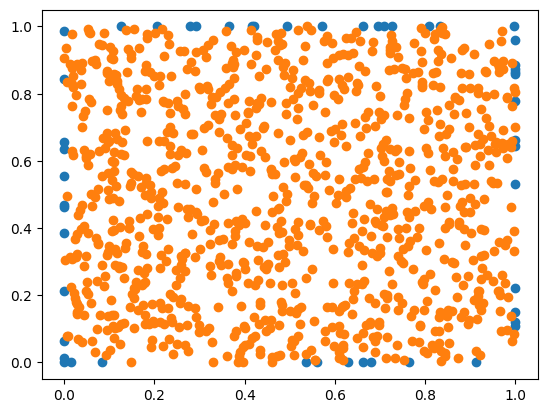

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from src import *
import matplotlib.pyplot as plt

# Set number of data points
N_b = 50
N_r = 10000

# set the boundary of the panel
a = 1
b = 1
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# set random seed for reproducible results
tf.random.set_seed(0)

# Boundary data on y edges
N_bhalf = int(N_b/2)
x_b1 = tf.random.uniform((N_bhalf,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_bhalf,1), 0.5, dtype=DTYPE)

# boundary data on x edges
y_b2 = tf.random.uniform((N_bhalf,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_bhalf,1), 0.5, dtype=DTYPE)

x_b = tf.Variable(tf.concat([x_b1, x_b2], axis=0))
y_b = tf.Variable(tf.concat([y_b1, y_b2], axis=0))
X_b = tf.Variable(tf.concat([x_b, y_b], axis=1))

# set boundary condition values (simply supported)
def fun_u_b(x, y):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)
u_b = fun_u_b(x_b, y_b)

# set collocation points in interior
x_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_b]
u_data = [u_b]

# plot the collocation points on the boundary
plt.scatter(x_b, y_b)
plt.scatter(x_r[:1000], y_r[:1000]) # only show 1000 of the points
plt.show()

In [2]:
import time
# tf.compat.v1.enable_eager_execution()

# choose buckling problem inputs
E = 70e9; nu = 0.3; thick = 0.005
D = E * thick**3 / 12.0 / (1 - nu**2)
# D = 1

# choose loading type (first just uniaxial loading in x-direction)
axial = True
if axial:
    Nxx, Nxy, Nyy = (1e3, 0, 0)
else: # shear
    Nxx, Nxy, Nyy = (0, 1e2, 0)

# initialize the model
model = PINN_EigenNet(
    lb, ub, num_hidden_layers=2, 
    activation=tf.keras.layers.LeakyReLU(negative_slope=0.1),
    kernel_initializer='he_normal'
)
# model.model.build(input_shape=(None, 2))
model.build(input_shape=(None, 2))

# Initilize solver
pinn = StrongFormBucklingPINN(D, Nxx, Nxy, Nyy, model, X_r)

print("Eager execution:", tf.executing_eagerly())
model.summary()
# exit(0)

# convert all to tf.Variable
# for layer in model.model.layers:
#     for var in layer.trainable_variables:
#         # Convert KerasVariable to tf.Variable
#         tf_var = tf.Variable(var)
#         # print(f"Converted to tf.Variable: {tf_var}")


# check something
# print("Trainable variables:", model.trainable_variables)
for var in model.trainable_variables:
    print(f"{type(var)=} {var=}")
    # print(type(var))
# print("Loss:", loss)


# Choose step sizes aka learning rate
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000,7000],[1e-1,1e-2,1e-3])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Start timer
t0 = time.time()
pinn.solve_with_TFoptimizer(optim, X_data, u_data, N=10001)

# Print computation time
print('\nComputation time: {} seconds'.format(time.time()-t0))

Eager execution: True


/home/seanfireball1/anaconda3/envs/F2F/lib/python3.9/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'pinn__eigen_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "pinn__eigen_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

TypeError: in user code:

    File "/home/seanfireball1/git/ml-pde-buckling/ml-pinn/src/base/pinn_solver.py", line 76, in train_step  *
        loss, grad_theta = self.get_grad(X, u)
    File "/home/seanfireball1/git/ml-pde-buckling/ml-pinn/src/base/pinn_solver.py", line 60, in get_grad  *
        loss = self.loss_fn(X, u)
    File "/home/seanfireball1/git/ml-pde-buckling/ml-pinn/src/base/pinn_solver.py", line 42, in loss_fn  *
        r = self.get_r()
    File "/home/seanfireball1/git/ml-pde-buckling/ml-pinn/src/pinn_strong_form.py", line 56, in get_r  *
        d3x = tape3.gradient(d2x, self.x)

    TypeError: Argument `target` should be a list or nested structure of Tensors, Variables or CompositeTensors to be differentiated, but received None.
